#  Singular Value Decomposition.

For more information, visit <a href='https://en.wikipedia.org/wiki/Singular_value_decomposition'>here.</a>

# Testing the SVD algorithm

In this implementation SVD is used on a high resolution image for dimension reduction. The image has 3 color channels RGB and the following steps were carried out:

1. The color channels are seperated into 3 different matrices.

2. Their respective SVD matrices are computed.

3. A rank value r is selected such that matrices U', Σ' and V\*' are of sizes m x r, r x r and r x n respectively. The matrix product of these matrices are the rank r approximation of the image of orignal decomposed matrices U, Σ and V\*, where "r" simply indicates the index of singular values and singular vectors.

4. The matrices are multiplied to give an approximate version of the original RGB channel matrices which are then stacked to give back an approximate version of the original image.

Below we define two functions *stack()* and *SVD()* for performing the following steps above.

The SVD function returns the approximated version of the original image, the Eigenvalues Σ of all the RGB channel matrices, and the memory consumption of matrices U', Σ' and V\*'

In [1]:
# Import necessary libraries for plotting and numerical computation
from matplotlib import pyplot as plt  # For plotting the results
from jax import numpy as jnp          # JAX's version of NumPy, optimized for GPU/TPU and autodiff
import tqdm                           # For displaying progress bars in loops

# Define a function to stack matrices along the third dimension (used for combining RGB channels)
def stack(matrices):
    # Use JAX's dstack function to stack matrices (typically RGB channels) along the third dimension
    return jnp.dstack([i for i in matrices])

# Define a function for performing Singular Value Decomposition (SVD) and rank reduction
def SVD(matrices, rank):
    # Initialize empty lists to store approximated matrices, singular values, and memory sizes
    approx_matrices = []  # List to store low-rank approximations of the matrices
    sigmas = []           # List to store singular values for each matrix
    memory_sizes = []      # List to track the memory usage of the reduced representations
        
    # Loop through each matrix (e.g., the R, G, B channels of an image)
    for idx, matrix in enumerate(matrices):
        # Perform SVD (Singular Value Decomposition) on the matrix
        # U, S, Vt are the left singular vectors, singular values, and right singular vectors, respectively
        U, S, Vt = jnp.linalg.svd(matrix, full_matrices=False)
        
        # Store the singular values in the sigmas list for further analysis or plotting
        sigmas.append(S)
        
        # Convert the singular values into a diagonal matrix (necessary for reconstructing the matrix)
        S = jnp.diag(S)
        
        # Truncate U, S, and Vt to the desired rank (retain only the top singular values and vectors)
        truncated_U = U[:, :rank]      # Keep only the first 'rank' columns of U
        truncated_S = S[:rank, :rank]  # Keep only the first 'rank' singular values
        truncated_V = Vt[:rank, :]     # Keep only the first 'rank' rows of Vt
        
        # Calculate the memory size for the truncated representation and store it
        memory_sizes.append(truncated_U.nbytes + truncated_S.nbytes + truncated_V.nbytes)
        
        # Reconstruct the approximated matrix using the truncated U, S, and Vt
        approx_matrices.append(truncated_U @ truncated_S @ truncated_V)
    
    # Sum up the memory sizes to get the total size of the approximated matrices
    total_size = sum(memory_sizes)
    
    # Return the stacked approximated matrices (e.g., RGB channels), singular values, and total memory size
    return stack(approx_matrices), sigmas, total_size


Below, we visualise the original image, determine it's memory, compute and store the Frobenius norm of the image matrices.

The Frobenius norm of a matrix is simply the two norm of that matrix stretched into a single vector. According to Ekard Young theorem, the best approximation of a given matrix M is simply the first r truncted Eigenvalues and Eigenvectors of the singular value decomposition. What this says in essence is that the best value that minimizes the difference between Frobenius norm of the original and approximated matrix is given by the matrix product of U', Σ' and V\*' from the above steps.

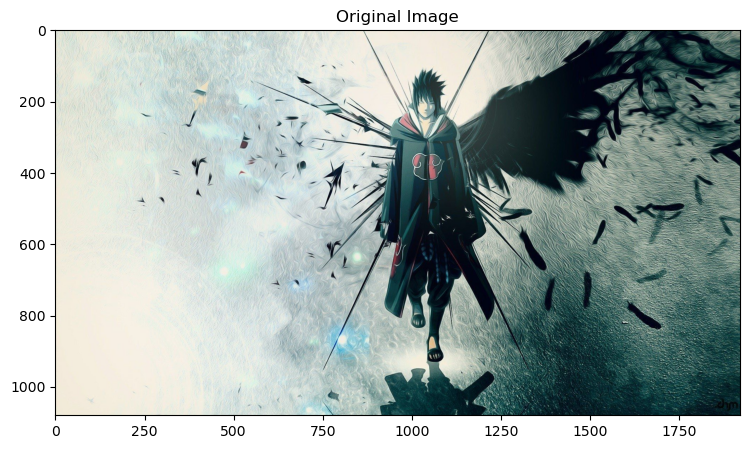

In [2]:
img = plt.imread('sasuke.jpg')
original_img_size = img.nbytes
img_frob_norm = jnp.linalg.norm(img)

plt.figure(figsize = (10, 5))
plt.imshow(img)
plt.title('Original Image')
plt.show()

Here the image is seprated in their respective channels

In [3]:
img_red = img[:, :, 0]
img_green = img[:, :, 1]
img_blue = img[:, :, 2]

Below we define a list of rank r values (10, 20, 30, ...100), iterate through the list using each r value for a rank r approximation of the image, compute the memory compression rate of the image, compute the difference between Frobenius norms of the original and approximated image and plot the image for a given r values for visual represention.

10it [00:12,  1.24s/it]


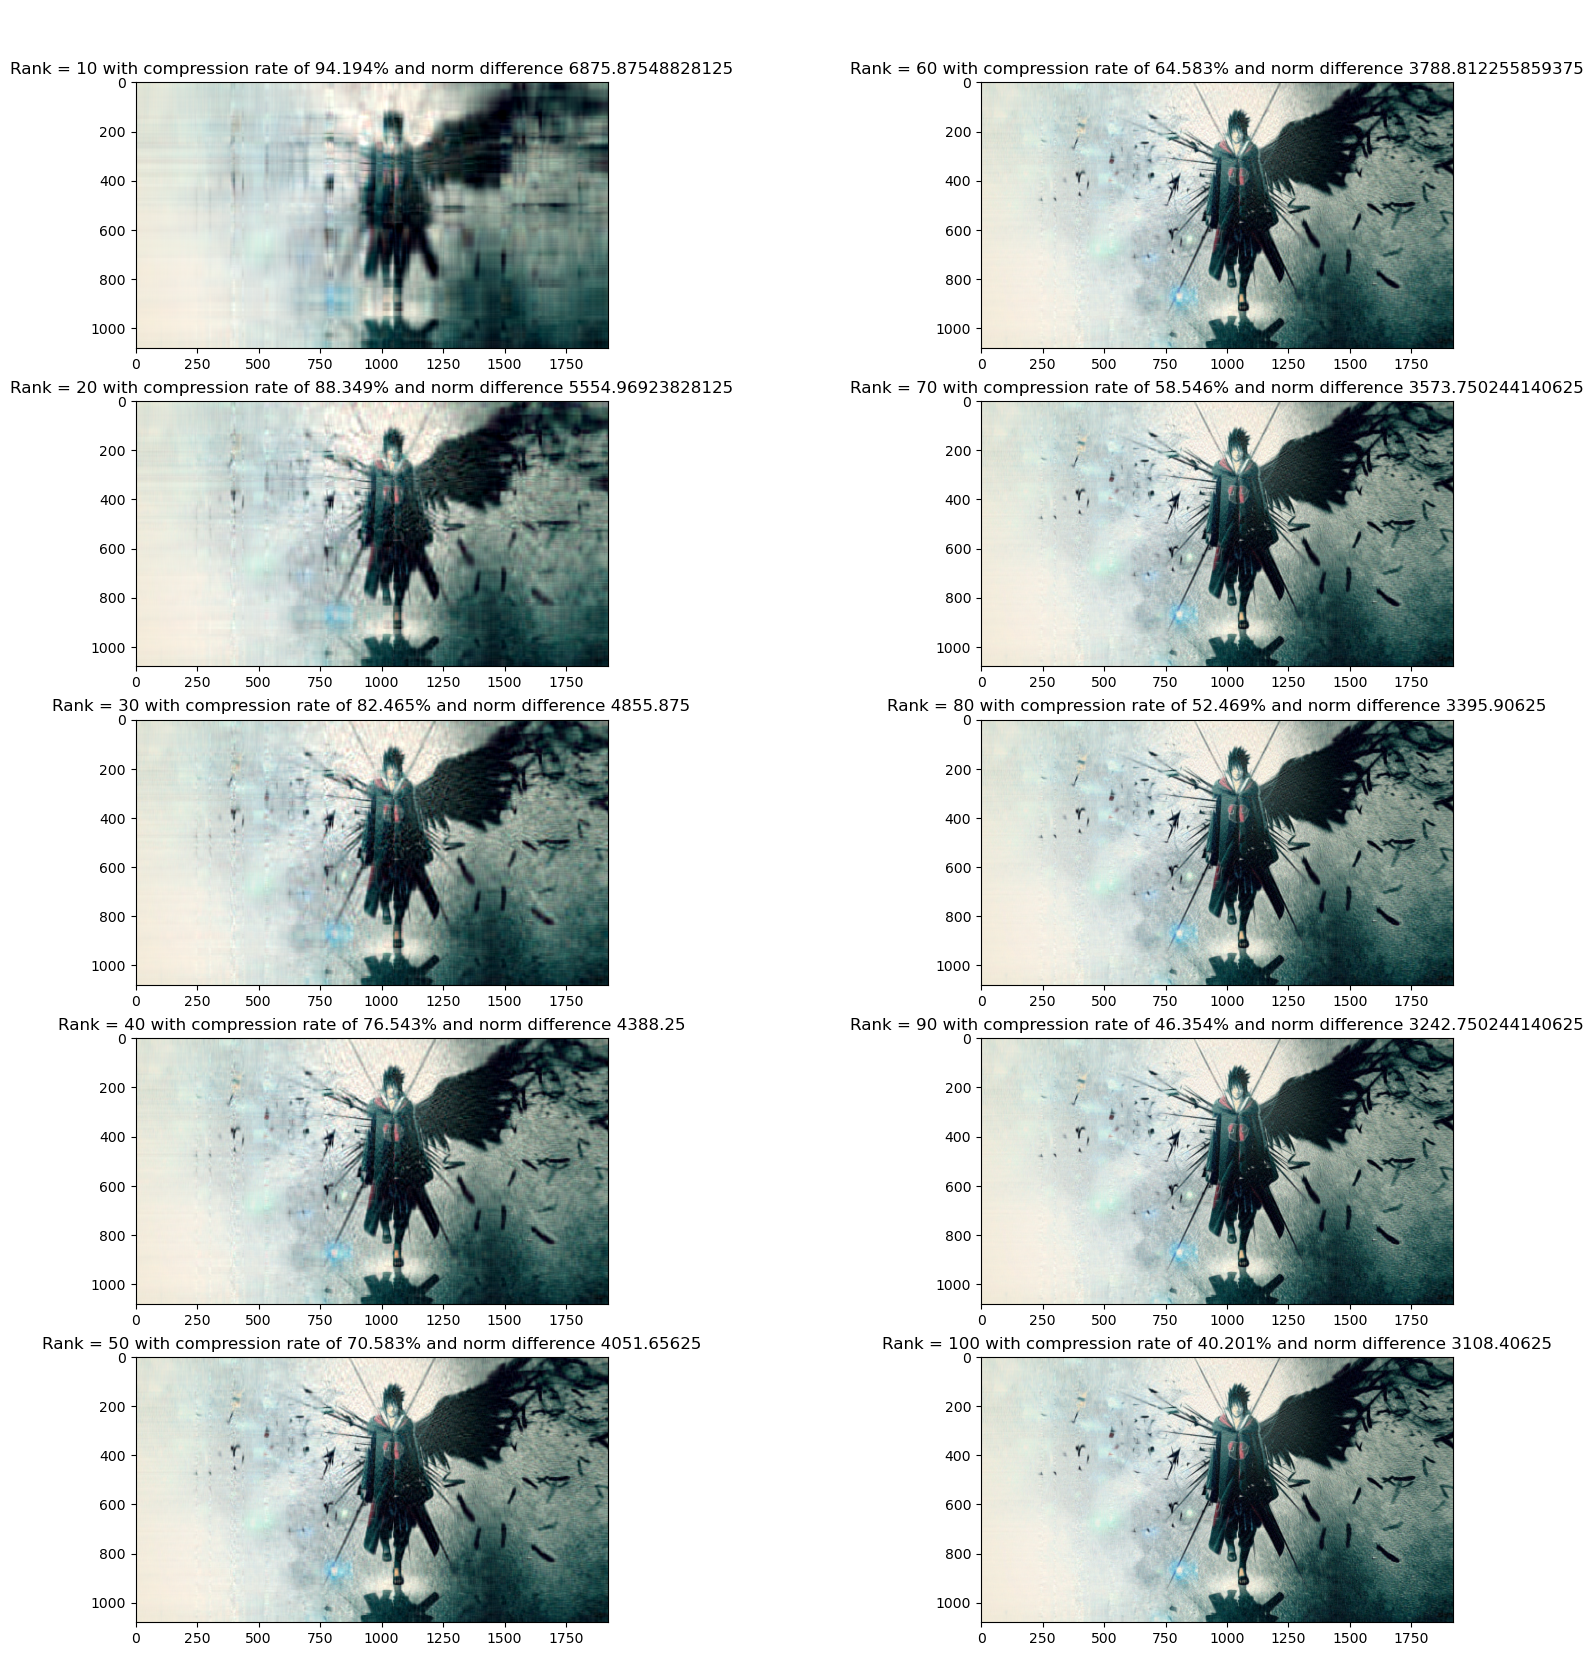

In [7]:
# Define a range of ranks for the SVD approximation, starting from 10 to 100, incrementing by 10
ranks = range(10, 110, 10)  # This will create the ranks: 10, 20, 30, ..., 100

# Create a figure with a 5x2 grid of subplots, each subplot will hold an image of different ranks
fig, axs = plt.subplots(5, 2, figsize=(20, 20))  # 5 rows, 2 columns of subplots with a figure size of 20x20

# Loop over the ranks, enumerating them so that both the index (idx) and the rank (r) are available
for idx, r in tqdm.tqdm(enumerate(ranks)):  # tqdm.tqdm is used to show a progress bar

    # Perform SVD on the red, green, and blue image channels with the current rank `r`
    approx_img, sigmas, memory_size = SVD([img_red, img_green, img_blue], rank=r)

    # Convert the approximated image to uint8 type for proper visualization
    approx_img = jnp.array(approx_img, dtype=jnp.uint8)

    # Compute the difference in Frobenius norm between the original image and the approximated image
    norm_diff = img_frob_norm - jnp.linalg.norm(approx_img)

    # Calculate the compression percentage, based on how much memory is saved after truncating the SVD
    compression_percentage = ((original_img_size - memory_size) / original_img_size) * 100

    # Calculate the position in the subplot grid: 
    # x determines the row (0-4), y determines the column (0 or 1)
    x = idx - 5 if (idx > 4) else idx  # Calculate the row index (0-4)
    y = 0 if (idx < 5) else 1  # Column is determined based on idx; first 5 go in the first column, next 5 in the second

    # Plot the approximated image in the appropriate subplot
    axs[x, y].imshow(approx_img)  # Display the image in the current subplot

    # Set the title of the current subplot, showing the rank, compression rate, and Frobenius norm difference
    axs[x, y].set_title(f'\n\n\nRank = {r} with compression rate of {round(compression_percentage, 3)}% and norm difference {round(norm_diff, 3)}')


# Image Compression Using Low-Rank Approximation

This image demonstrates the **effect of rank reduction** in image compression using Singular Value Decomposition (SVD). Let's break down the details:

### 1. **Rank of the Matrix (Rank = 10)**
- In this example, the rank used for the image reconstruction is **10**. This means that only the top 10 singular values (and their associated singular vectors) were used to approximate the original image.
- In SVD-based compression, the **rank** determines how many singular values (and corresponding vectors) are retained from the original image. Higher rank approximations retain more information but require more storage.

### 2. **Compression Rate (94.194%)**
- The **compression rate** is a measure of how much the original image has been reduced in size by the rank reduction.
- A compression rate of **94.194%** means that the compressed image uses only 5.806% of the data from the original image.
- Compression rate can be calculated as:
  $
  \text{Compression Rate} = \left( 1 - \frac{\text{retained rank}}{\text{total rank}} \right) \times 100
  $
  
  The retained rank is the number of singular values you decide to keep.
  
  In this case, the retained rank is 10, and the total rank is much higher (likely equal to the number of rows or columns in the original image matrix).

### 3. **Norm Difference (6875.87548828125)**
- The **norm difference** represents the difference in the **Frobenius norm** between the original image and the compressed (rank-reduced) image.
- The Frobenius norm measures the sum of the squared differences between corresponding pixel values of the original and compressed images.
- A norm difference of **6875.875** indicates the magnitude of information loss when reducing the image to rank 10. Higher values of the norm difference indicate more loss of information.

### 4. **Visual Effect of Rank Reduction**
- The image shows visible artifacts due to the rank reduction. The image is blurry, and fine details are lost. This is expected when using a low-rank approximation (rank 10 in this case).
- The blurring occurs because low-rank approximations retain only the most significant patterns (high-level structure), and smaller details (which are represented by smaller singular values) are discarded.

### 5. **Singular Value Decomposition (SVD) Overview**
- In SVD, a matrix (in this case, the image) is decomposed into three matrices:
 $
  A = U \Sigma V^T
  $
  where:
  - $A$ is the original image matrix.
  - $U$ and $V$ are orthogonal matrices containing the singular vectors.
  - $\Sigma$ is a diagonal matrix containing the singular values, which represent the importance of each corresponding singular vector in describing the image.

- By retaining only the top `k` singular values and their corresponding vectors, we get a **rank-k approximation** of the image. This reduces the size of the image while maintaining the most important features.


The image serves as an example of how low-rank approximation can be used to compress images, while illustrating the trade-off between compression efficiency and image quality.


From the above plot, we can see that at r = 10, the approximated image is blurred and the memory usage of matrices U', Σ' and V\*' for all channels combined is 94% lesser than the orignal. Similarly, at r = 20, the approximated image is slightly better than the previous one, with 88% less memory than the original image. At rank=100, we got an almost perfect approximation of the image, with 40% less memory than the original image.

Below, we plot the Eigenvalues $\sum$ from the decomposition of all the different channel matrices on a log plot. This plot aids us to indicates what rank or set of singluar / eigenvalues hold most information and what rank or set of singluar / eigenvalues hold least information pertaining to the channel matrices.

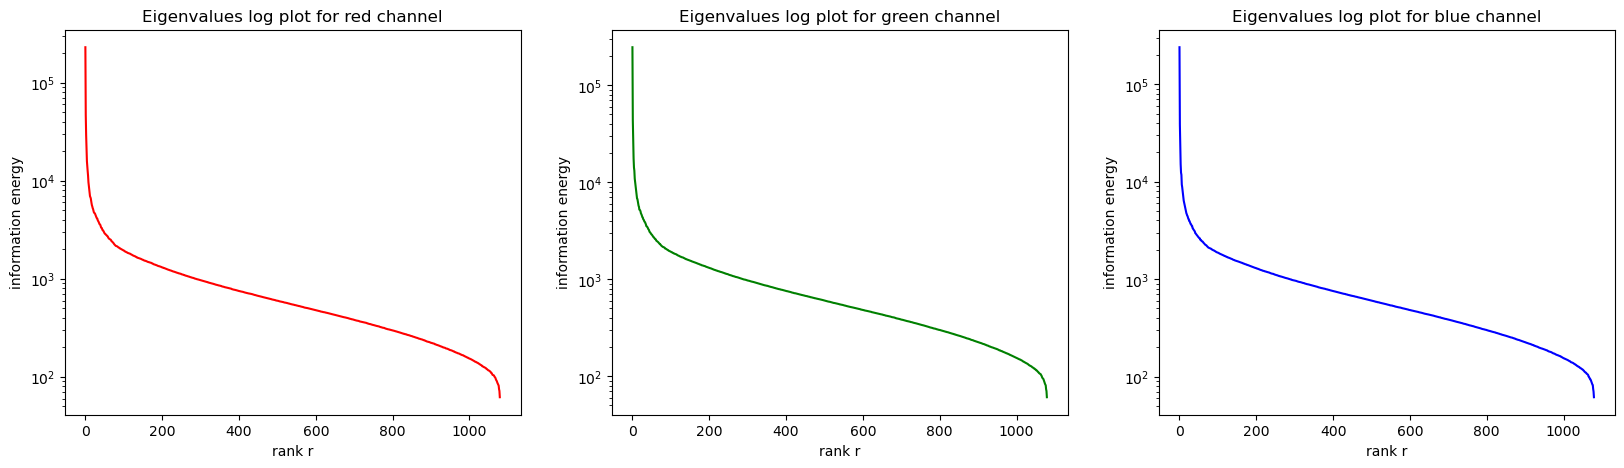

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
channels = ['red', 'green', 'blue']
for idx, S in enumerate(sigmas):
    axs[idx].semilogy(S, c=channels[idx])
    axs[idx].set_ylabel('information energy')
    axs[idx].set_xlabel('rank r')
    axs[idx].set_title(f'Eigenvalues log plot for {channels[idx]} channel')
    

### Variance and Singular Values

Each singular value represents a portion of the total variance in the original matrix. Larger singular values capture more variance, while smaller ones capture less.

The total information energy in the original matrix is proportional to the sum of the squared singular values:

$
\text{Total Information Energy} = \sum_{i=1}^{r} \sigma_i^2
$

Where:
- $ \sigma_i $ represents the $i^{\text{th}}$ singular value.
- $ r $ is the rank or the number of singular values used.

$
\text{Cumulative Information Energy} = \sum_{i=1}^{k<r} \sigma_i^2
$


### Explanation of Axes:

- **X-axis (Rank $r$)**: Represents the rank or the number of singular values/components used.
- **Y-axis (Information Energy)**: Represents the magnitude of the singular values (in log scale), which quantifies how much variance is captured by each singular value.

### Interpretation

- The sharp drop in the singular values in the first few ranks indicates that most of the information energy is captured by the first few components (or ranks). This means that these components are the most important for capturing the variance or structure of the original image.
- After the initial drop, the singular values decay more slowly, indicating that the later components contribute much less information. These components often represent noise or less important details.


From the three different plots, we can inspect that the rank of the singular values that hold most information pertaining the matrices seem to be even less than 100. This plot is very useful for selecting the appropriate r value for truncating the decomposition matrices for dimension reduction.

Similar to the plot above, the plot below also tells us what rank value or set of singular values hold most or least of the information pertaining to the image. The plot tells us the percentage of information (on the y-axis) held by a given rank value (on the x-axis).

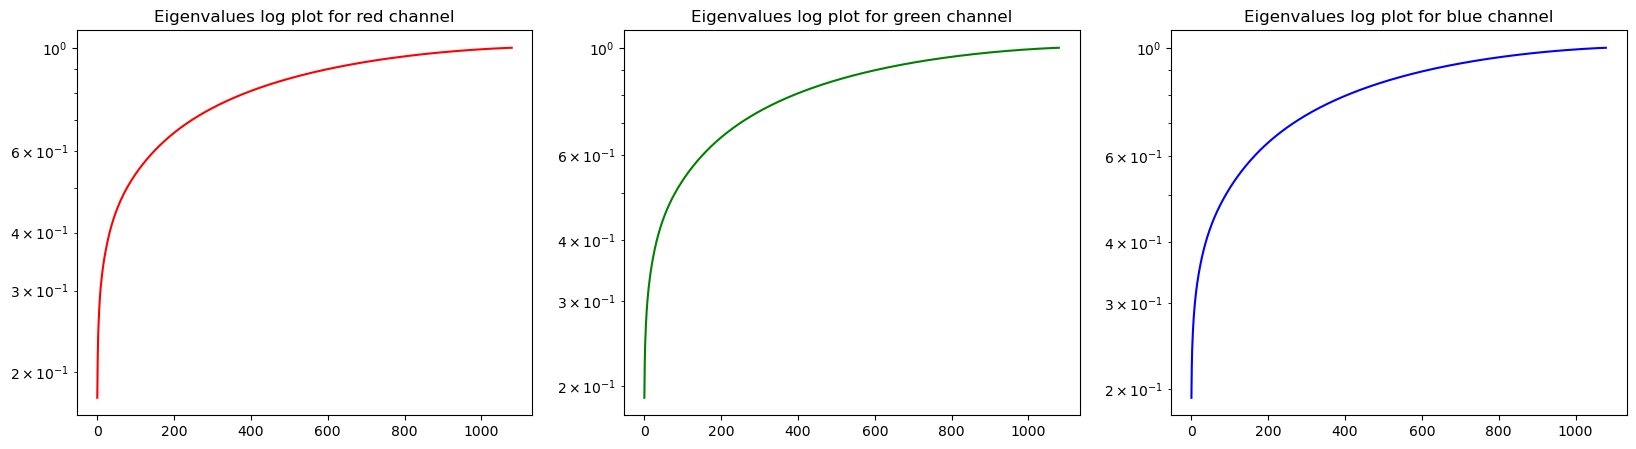

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
channels = ['red', 'green', 'blue']
for idx, S in enumerate(sigmas):
    sigma_cumsum = jnp.cumsum(S)
    sigma_sum = jnp.sum(S)
    axs[idx].semilogy(sigma_cumsum/sigma_sum, c=channels[idx])
    axs[idx].set_title(f'Eigenvalues log plot for {channels[idx]} channel')

The **x-axis** represents the **singular value index** (eigenvalue index), and the **y-axis** (logarithmic scale) represents the **cumulative sum of singular values**, normalized by the total sum of singular values.

The curve starts steep, indicating that the **first few singular values capture most of the information** (energy/variance) in every channel (R-G-B). After the initial steep rise, the curve flattens, suggesting that **higher-index singular values contribute little** to the total variance.

**Interpretation**:  channel has a few dominant components, meaning most of the information in channel can be captured using a small number of singular values.


NB: *SVDs can be used to accertain the principle components of turbulent flow that happens to have very high degree of flow freedom, hence reducing the overall dimension of the flow data for modeling.*